# Yoochoose: Make final predictions and prepare submission

In [1]:
%pylab inline
import os
import sklearn
import pandas
import collections
from scipy.optimize import fmin_powell

Populating the interactive namespace from numpy and matplotlib


In [2]:
purchase_predictions_path = '../data/predictions/purchase/'
item_predictions_path = '../data/predictions/item/'

In [3]:
!mkdir -p exports

## Load validation predictions

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

In [5]:
valid_purchase = pandas.read_csv(
    os.path.join(purchase_predictions_path, 'valid'),
    sep='\t',
    names=['session_id', 'target', 'item_id', 'weight', 'prediction'],
)

valid_item = pandas.read_csv(
    os.path.join(item_predictions_path, 'valid'),
    sep='\t',
    names=['session_id', 'target', 'item_id', 'weight', 'prediction'],
)

## Items prediction threshold

In [6]:
def jaccard_by_thresh(thresh):
    valid_item['decision'] = valid_item['prediction'] >= thresh
    valid_item['union'] = valid_item['target'] | valid_item['decision']
    valid_item['intersection'] = valid_item['target'] & valid_item['decision']
    union_and_intersection = valid_item.ix[:, ['session_id', 'union', 'intersection']].groupby('session_id').sum()
    jaccard = union_and_intersection['intersection'].astype(float) / union_and_intersection['union']
    jaccard.name = 'jaccard'
    return jaccard

Best point: thresh = -0.433641, probability = 0.393257, jaccard = 0.765462


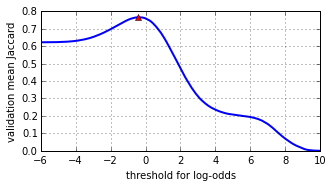

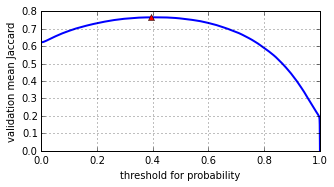

In [7]:
item_thresh_values = linspace(valid_item['prediction'].min(), valid_item['prediction'].max(), 300)
item_thresh_prob = 1.0 / (1.0 + np.exp(-item_thresh_values))
item_thresh_jaccard = np.array([
    jaccard_by_thresh(thresh).mean() for thresh in item_thresh_values
])
optimal_idx = np.argmax(item_thresh_jaccard)
optimal_item_thresh = item_thresh_values[optimal_idx]
optimal_item_thresh_prob = item_thresh_prob[optimal_idx]
optimal_item_jaccard = item_thresh_jaccard[optimal_idx]


figure(figsize=(5, 2.5))
plot(item_thresh_values, item_thresh_jaccard, linewidth=2)
plot(optimal_item_thresh, optimal_item_jaccard, '^r')
xlabel('threshold for log-odds')
ylabel('validation mean Jaccard')
grid(True)
xlim([-6, 10])
savefig('exports/item_prediction_thresh_jaccard.pdf', bbox_inches='tight')

figure(figsize=(5, 2.5))
plot(item_thresh_prob, item_thresh_jaccard, linewidth=2)
plot(optimal_item_thresh_prob, optimal_item_jaccard, '^r')
xlabel('threshold for probability')
ylabel('validation mean Jaccard')
grid(True)
savefig('exports/item_prediction_thresh_jaccard_prob.pdf', bbox_inches='tight')

print 'Best point: thresh = %f, probability = %f, jaccard = %f' % (
    optimal_item_thresh, 1.0/(1.0 + np.exp(-optimal_item_thresh)), item_thresh_jaccard[optimal_idx])

In [8]:
xopt = fmin_powell(lambda x: -jaccard_by_thresh(x[0]).mean(), x0=np.array(optimal_item_thresh), xtol=1e-7)
optimal_item_thresh = float(xopt)

print 'After tuning: thresh = %f, probability = %f, jaccard = %f' % (
    optimal_item_thresh, 1.0/(1.0 + np.exp(-optimal_item_thresh)), item_thresh_jaccard[optimal_idx])

Optimization terminated successfully.
         Current function value: -0.765529
         Iterations: 1
         Function evaluations: 36
After tuning: thresh = -0.430068, probability = 0.394110, jaccard = 0.765462


## Session purchase threshold

In [9]:
jaccard = jaccard_by_thresh(optimal_item_thresh)
valid_purchase_items = valid_purchase.join(jaccard, on='session_id', how='left').fillna(0)

In [10]:
valid_purchase_items.head()

,session_id,target,item_id,weight,prediction,jaccard
0,4636233,0,0,0,-2.424682,0
1,8961633,0,0,0,-4.398143,0
2,835233,0,0,0,-3.775572,0
3,1097433,0,0,0,-4.488155,0
4,2539233,0,0,0,-4.899196,0


In [11]:
session_predictions = valid_purchase_items\
    .ix[:, ['prediction', 'jaccard', 'target']]\
    .sort('prediction', ascending=False)\
    .reset_index(drop=True)
    
session_predictions['probability'] = 1.0 / (1.0 + np.exp(-session_predictions['prediction']))
session_predictions['sum_jaccard'] = session_predictions['jaccard'].cumsum()
session_predictions['tp'] = session_predictions['target'].cumsum()
session_predictions['fp'] = (1 - session_predictions['target']).cumsum()

n_positive = session_predictions['target'].sum()
n_negative = (1 - session_predictions['target']).sum()
n_sessions = session_predictions.shape[0]

session_predictions['score_tpfp'] = (float(n_positive) / n_sessions) * (session_predictions['tp'] - session_predictions['fp'])
session_predictions['score'] = session_predictions['score_tpfp'] + session_predictions['sum_jaccard']

optimal_idx = session_predictions['score'].argmax()
optimal_purchase_thresh = session_predictions.ix[optimal_idx, 'prediction']
optimal_purchase_thresh_prob = session_predictions.ix[optimal_idx, 'probability']
valid_score = session_predictions.ix[optimal_idx, 'score']

print 'Best purchase thresh: thresh = %f, probability = %f, score = %f' % (
    optimal_purchase_thresh, optimal_purchase_thresh_prob, valid_score)

session_predictions.ix[optimal_idx, :]

Best purchase thresh: thresh = -2.967180, probability = 0.048931, score = 20904.575474


prediction         -2.967180
jaccard             1.000000
target              1.000000
probability         0.048931
sum_jaccard     29770.947152
tp              39279.000000
fp             200760.000000
score_tpfp      -8866.371678
score           20904.575474
Name: 240038, dtype: float64

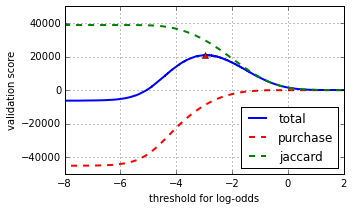

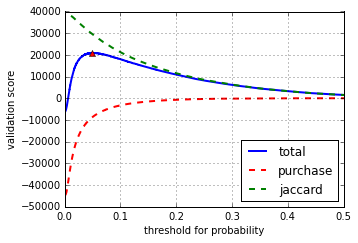

In [12]:
figure(figsize=(5, 3))
plot(session_predictions['prediction'], session_predictions['score'], linewidth=2)
plot(session_predictions['prediction'], session_predictions['score_tpfp'], 'r--', linewidth=2)
plot(session_predictions['prediction'], session_predictions['sum_jaccard'], 'g--', linewidth=2)
plot(session_predictions.ix[optimal_idx, 'prediction'], session_predictions.ix[optimal_idx, 'score'], '^r')
grid(True)
xlabel('threshold for log-odds')
ylabel('validation score')
ylim((-50000, 50000))
legend(['total', 'purchase', 'jaccard'], loc='lower right')
xlim([-8, 2])

savefig('exports/purchase_prediction_thresh_score.pdf', bbox_inches='tight')

figure(figsize=(5, 3.5))
plot(session_predictions['probability'], session_predictions['score'], linewidth=2)
plot(session_predictions['probability'], session_predictions['score_tpfp'], 'r--', linewidth=2)
plot(session_predictions['probability'], session_predictions['sum_jaccard'], 'g--', linewidth=2)
plot(session_predictions.ix[optimal_idx, 'probability'], session_predictions.ix[optimal_idx, 'score'], '^r')
grid(True)
xlabel('threshold for probability')
ylabel('validation score')
legend(['total', 'purchase', 'jaccard'], loc='lower right')
xlim([0, 0.5])

savefig('exports/purchase_prediction_thresh_score_prob.pdf', bbox_inches='tight')

## Make a submission

#### Load test predictions and apply thresholds

In [13]:
test_purchase = pandas.read_csv(
    os.path.join(purchase_predictions_path, 'test'), 
    sep='\t',
    names=['session_id', 'positive', 'item_id', 'weight', 'prediction'],
)
test_purchase['positive'] = (test_purchase['prediction'] >= optimal_purchase_thresh)

test_item = pandas.read_csv(
    os.path.join(item_predictions_path, 'test'), 
    sep='\t',
    names=['session_id', 'bought', 'item_id', 'weight', 'prediction'],
)
test_item['bought'] = (test_item['prediction'] >= optimal_item_thresh)

In [14]:
bought_in_session = collections.defaultdict(set)
bought_df = test_item.ix[test_item['bought'], ['session_id', 'item_id']]
for session_id, item_id in zip(bought_df['session_id'].values, bought_df['item_id'].values):
    bought_in_session[session_id].add(item_id)
    
with open('submission', 'wt') as fout:
    positive_session_ids = test_purchase.ix[test_purchase.ix[:, 'positive'], 'session_id'].values
    for session_id in positive_session_ids:
        if len(bought_in_session[session_id]) > 0:
            print >> fout, str(session_id) + ';' + ','.join(map(str, bought_in_session[session_id]))

In [15]:
!wc -l submission
!du -hs submission

592785 submission
17M	submission


# Prediction quality

In [16]:
from sklearn import metrics

## Purchase classifier

Purchase classifier

Optimal purchase decision rule:
    [ prediction > -2.967180 ]
    [ probability > 0.048931 ]

Positive: actual 5.49%, predicted 25.95%
TPR = 0.773254, FPR = 0.229609, 1-TPR = 0.226746
Precision = 0.163636, Recall = 0.773254
AUC = 0.850798, Gini = 0.701595


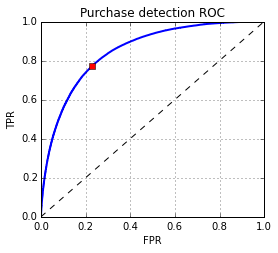

In [17]:
print 'Purchase classifier'
print 

fpr, tpr, thresh = roc_curve(valid_purchase['target'], valid_purchase['prediction'])


figure(figsize=(4, 3.5))
plot(fpr, tpr, linewidth=2)
plot([0, 1], [0, 1], '--k')
grid(True)
title('Purchase detection ROC')
xlabel('FPR')
ylabel('TPR')

print 'Optimal purchase decision rule:'
print '    [ prediction > %f ]' % optimal_purchase_thresh
print '    [ probability > %f ]' % optimal_purchase_thresh_prob
print 


purchase_actual = valid_purchase['target']
purchase_predicted = valid_purchase['prediction'] >= optimal_purchase_thresh
print 'Positive: actual %.2f%%, predicted %.2f%%' % (purchase_actual.mean() * 100, purchase_predicted.mean() * 100)

purchase_tpr = (purchase_predicted & purchase_actual).astype(float).sum() / purchase_actual.sum()
purchase_fpr = (purchase_predicted & (1 - purchase_actual)).astype(float).sum() / (1 - purchase_actual).sum()

print 'TPR = %f, FPR = %f, 1-TPR = %f' % (purchase_tpr, purchase_fpr, 1-purchase_tpr)
print 'Precision = %f, Recall = %f' % (metrics.precision_score(purchase_actual, purchase_predicted), 
                                       metrics.recall_score(purchase_actual, purchase_predicted))

auc_purchase = roc_auc_score(valid_purchase['target'], valid_purchase['prediction'])
print 'AUC = %f, Gini = %f' % (auc_purchase, 2*auc_purchase - 1)

plot(purchase_fpr, purchase_tpr, 'rs')

savefig('exports/purchase_prediction_roc.pdf')

## Item classifier

Item classifier

Optimal item decision rule:
    [ prediction > -0.430068 ]
    [ probability > 0.394110 ]

Positive: actual 45.30%, predicted 51.22%
TPR = 0.852283, FPR = 0.230477, 1-TPR = 0.147717
Precision = 0.753841, Recall = 0.852283
AUC = 0.898442, Gini = 0.796885


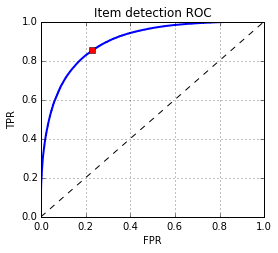

In [18]:
print 'Item classifier'
print

fpr, tpr, thresh = roc_curve(valid_item['target'], valid_item['prediction'])
auc_bought = roc_auc_score(valid_item['target'], valid_item['prediction'])

figure(figsize=(4, 3.5))
plot(fpr, tpr, linewidth=2)
plot([0, 1], [0, 1], '--k')
grid(True)
xlabel('FPR')
ylabel('TPR')
title('Item detection ROC')

print 'Optimal item decision rule:'
print '    [ prediction > %f ]' % optimal_item_thresh
print '    [ probability > %f ]' % (1.0 / (1 + np.exp(-optimal_item_thresh)))
print 

item_actual = valid_item['target']
item_predicted = valid_item['prediction'] >= optimal_item_thresh
print 'Positive: actual %.2f%%, predicted %.2f%%' % (item_actual.mean() * 100, item_predicted.mean() * 100)

item_tpr = (item_predicted & item_actual).astype(float).sum() / item_actual.sum()
item_fpr = (item_predicted & (1 - item_actual)).astype(float).sum() / (1 - item_actual).sum()

print 'TPR = %f, FPR = %f, 1-TPR = %f' % (item_tpr, item_fpr, 1-item_tpr)
print 'Precision = %f, Recall = %f' % (metrics.precision_score(item_actual, item_predicted), 
                                       metrics.recall_score(item_actual, item_predicted))

auc_item = roc_auc_score(valid_item['target'], valid_item['prediction'])
print 'AUC = %f, Gini = %f' % (auc_item, 2*auc_item - 1)

plot(item_fpr, item_tpr, 'rs')

savefig('exports/item_prediction_roc.pdf')

## Answer to the task

In [20]:
purchase_tp = (purchase_actual & purchase_predicted).sum()
purchase_fp = ((1 - purchase_actual) & purchase_predicted).sum() 
score_tpfp = (float(purchase_actual.sum()) / purchase_actual.shape[0]) * (purchase_tp - purchase_fp)
score_jaccard = valid_purchase_items.ix[purchase_predicted, 'jaccard'].sum()
score = score_tpfp + score_jaccard

purchase_max_tp = purchase_actual.sum()
purchase_max_fp = 0
score_max_tpfp = (float(purchase_actual.sum()) / purchase_actual.shape[0]) * (purchase_max_tp - purchase_max_fp)
score_max_jaccard = purchase_actual.sum()
score_max = score_max_tpfp + score_max_jaccard

print 'Quality of answers to the task'
print 

print 'Computed on validation set (10% of train set)'
print 

print 'Max achievable score: %10.2f = %.2f (max purchase) + %10.2f (max jaccard)' % (
    score_max, score_max_tpfp, score_max_jaccard) 
print 'Score gained:         %10.2f = %.2f (purchase)    + %10.2f (jaccard)' % (
    score, score_tpfp, score_jaccard)
print 'Gained percent: %.2f%%' % (score / score_max * 100)

Quality of answers to the task

Computed on validation set (10% of train set)

Max achievable score:   53586.09 = 2789.09 (max purchase) +   50797.00 (max jaccard)
Score gained:           20904.58 = -8866.37 (purchase)    +   29770.95 (jaccard)
Gained percent: 39.01%
